# Part 1: Define an RL Environment

In [451]:
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np

In [452]:
class GridEnvironment(gym.Env):
    metadata = { 'render.modes': [] }
    
    def __init__(self):

        self.observation_space = spaces.Discrete(9)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 20

        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [3, 3]
        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 10
        self.state[tuple(self.goal_pos)] = 8
        self.state[tuple([3,0])] = 2
        self.state[tuple([1,1])] = 4
        self.state[tuple([0,2])] = 4
        self.state[tuple([2,2])] = 6

        
    def reset(self, **kwargs):
        self.index = 0
        self.timestep = 0
        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 10
        self.state[tuple(self.goal_pos)] = 8
        self.state[tuple([3,0])] = 2
        self.state[tuple([1,1])] = 4
        self.state[tuple([0,2])] = 4
        self.state[tuple([2,2])] = 6
        observation = self.state.flatten()

        info = {}

        return self.index
    
    def step(self, action):
        past = self.state.flatten()
        if action == 0:
          self.agent_pos[0] += 1
          move = 'down'
        if action == 1:
          self.agent_pos[0] -= 1
          move = 'up'
        if action == 2:
          self.agent_pos[1] += 1
          move = 'right'
        if action == 3:
          self.agent_pos[1] -= 1
          move = 'left'

        self.agent_pos = np.clip(self.agent_pos, 0, 3)

        self.state = np.zeros((4,4))
        self.state[tuple([3,0])] = 2
        self.state[tuple([1,1])] = 4
        self.state[tuple([0,2])] = 4
        self.state[tuple([2,2])] = 6
        self.state[tuple(self.agent_pos)] = 10
        self.state[tuple(self.goal_pos)] = 8
        observation = self.state.flatten()
        reward = 0
        if np.array_equal(observation, past):
           reward = 0
        elif np.array_equal(self.agent_pos, self.goal_pos):
          reward = 10
        elif np.array_equal(self.agent_pos, [1,1]):
           reward = -2
        elif np.array_equal(self.agent_pos, [3,0]):
           reward = -5
        elif np.array_equal(self.agent_pos, [2,2]):
           reward = 2
        elif np.array_equal(self.agent_pos, [0,2]):
           reward = -2
        
        self.timestep += 1

        terminated = False
        if reward == 10:
           terminated = True
        if self.timestep > self.max_timesteps:
           terminated = True
        truncated = True if np.all((self.agent_pos >=0 ) & (self.agent_pos <= 3)) else False

        self.index = self.agent_pos[0]*4+self.agent_pos[1]

        info = "Current position is: " + str(self.agent_pos) +'\nCUrrent Index:'+str(self.index) + "\nAction taken was: " + str(move) + "\nReward is: " + str(reward)
        
        return self.index, reward, terminated, info
        
    def render(self):
        output_grid = plt.grid(which = "minor")
        plt.xticks([0,1,2,3])
        plt.yticks([0,1,2,3])
        plt.imshow(self.state)

In [453]:
class RandomAgent:
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space

  def step(self):
    return np.random.choice(self.action_space.n)

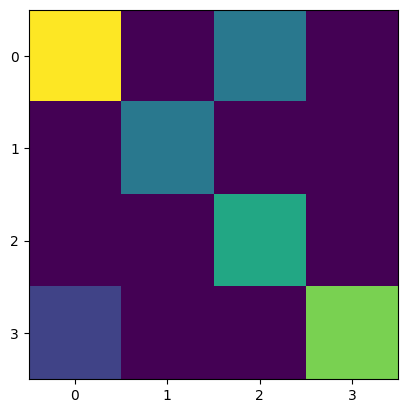

In [454]:
env = GridEnvironment()
agent = RandomAgent(env)

env.reset()

terminated, truncated = False, False
output_grid = plt.grid(which = "minor")
plt.xticks([0,1,2,3])
plt.yticks([0,1,2,3])
env.render()


Current position is: [1 0]
CUrrent Index:4
Action taken was: down
Reward is: 0


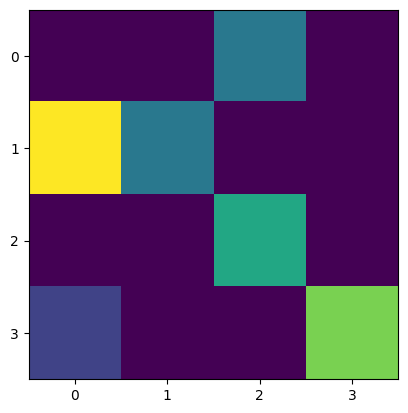

In [455]:
print(env.step(agent.step())[3])
env.render()

Current position is: [2 0]
CUrrent Index:8
Action taken was: down
Reward is: 0


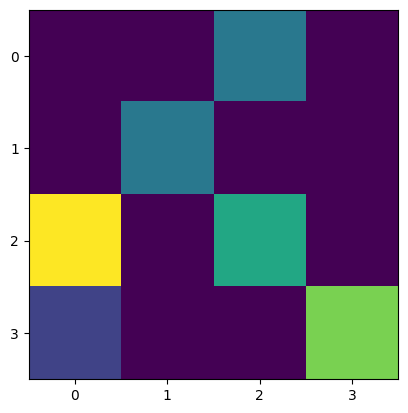

In [456]:
print(env.step(agent.step())[3])
env.render()

Current position is: [2 1]
CUrrent Index:9
Action taken was: right
Reward is: 0


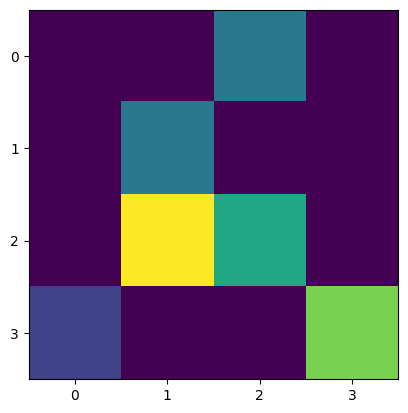

In [457]:
print(env.step(agent.step())[3])
env.render()

Current position is: [2 0]
CUrrent Index:8
Action taken was: left
Reward is: 0


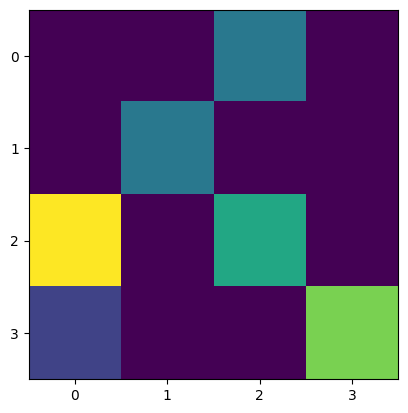

In [458]:
print(env.step(agent.step())[3])
env.render()

Current position is: [2 0]
CUrrent Index:8
Action taken was: left
Reward is: 0


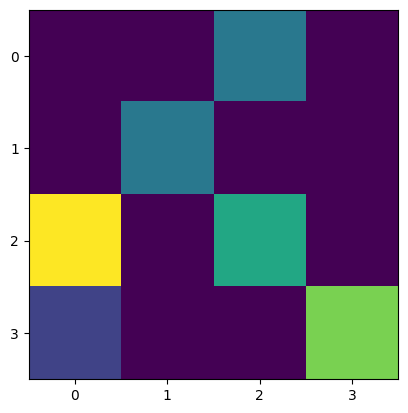

In [459]:
print(env.step(agent.step())[3])
env.render()

Current position is: [2 1]
CUrrent Index:9
Action taken was: right
Reward is: 0


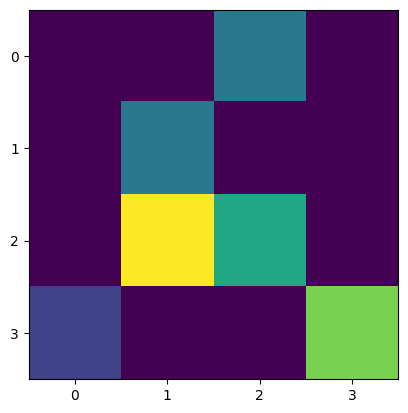

In [460]:
print(env.step(agent.step())[3])
env.render()

Current position is: [2 0]
CUrrent Index:8
Action taken was: left
Reward is: 0


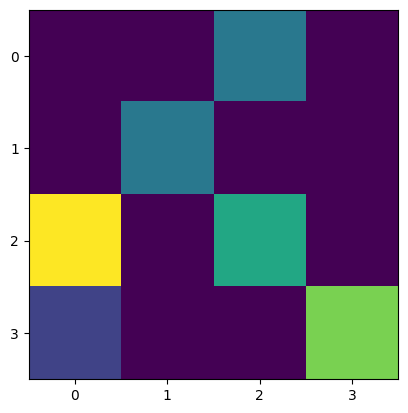

In [461]:
print(env.step(agent.step())[3])
env.render()

Current position is: [2 0]
CUrrent Index:8
Action taken was: left
Reward is: 0


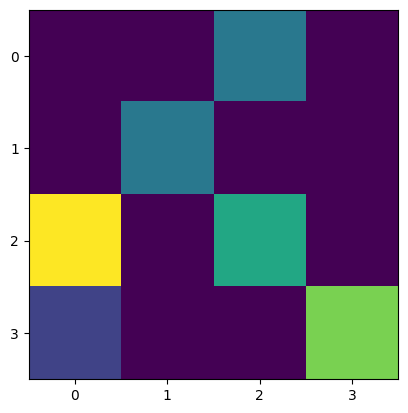

In [462]:
print(env.step(agent.step())[3])
env.render()

Current position is: [2 1]
CUrrent Index:9
Action taken was: right
Reward is: 0


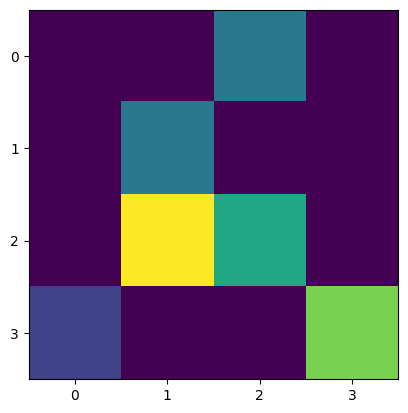

In [463]:
print(env.step(agent.step())[3])
env.render()

# Part 2: Solve your environment using - SARSA

In [516]:
#Choose Action
def choose_action(state,epsilon):
    if np.random.uniform(0, 1) < epsilon:
        action = env.action_space.sample()
    else:
        action = np.argmax(Q[state, :])
    return action

#Update Q
def update(state1, state2, reward, action, action2):
    predict = Q[state1, action]
    target = reward + gamma * Q[state2, action2]
    Q[state1, action] = Q[state1, action] + alpha * (target - predict)

In [465]:
epsilon = 0.5
episodes = 1000
max_steps = 10
alpha = 0.85
gamma = 0.95
epsilon_decay = .99

Q = np.zeros((16, 4))

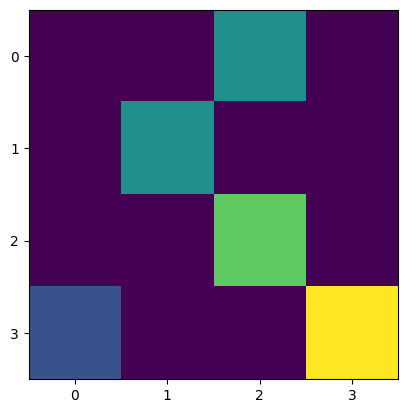

In [466]:
#Initializing the reward
reward_val=0
reward_list = []
time_list = []
eps = []

#SARSA
for episode in range(episodes):
    t = 0
    env.reset()
    state1 = 0
    action1 = choose_action(state1,epsilon)
    reward_val = 0
 
    while t < max_steps:
        # #Visualizing the training
        # env.render()
         
        #Take a time step
        state2, reward, done, info = env.step(action1)
 
        #choose next action
        action2 = choose_action(state2,epsilon)
         
        #update Q vals
        update(state1, state2, reward, action1, action2)

        #keep track of current state
        state1 = state2
        action1 = action2
         
        #Updating the respective values
        t += 1
        reward_val += reward
         
        #If at the end of learning process
        if done:
            break
    reward_list.append(reward_val)
    time_list.append(t)
    eps.append(epsilon)
    epsilon = epsilon * epsilon_decay

env.render()

Performance :  10.61


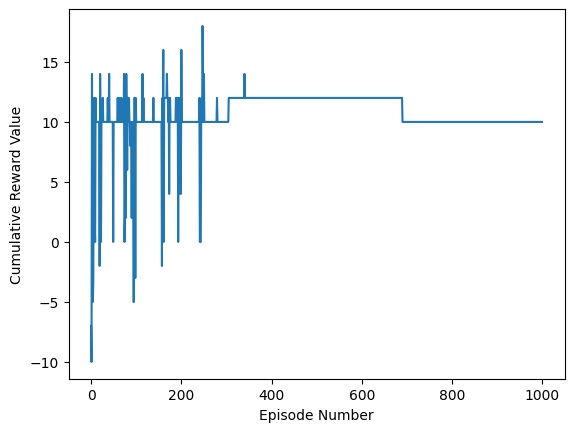

In [467]:
import matplotlib.pyplot as plt
print ("Performance : ", sum(reward_list)/episodes)
plt.plot(list(range(episodes)),reward_list)
plt.xlabel("Episode Number")
plt.ylabel("Cumulative Reward Value")
plt.show()

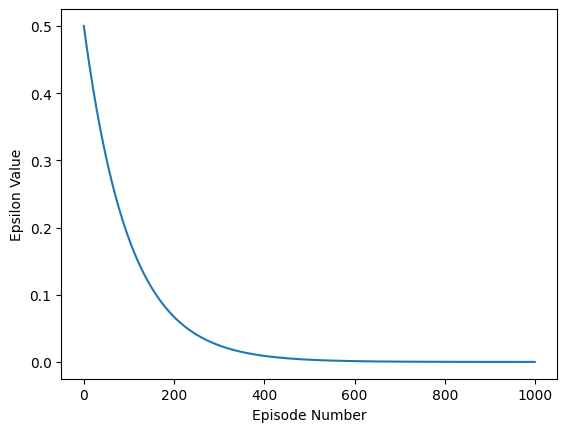

In [468]:
plt.plot(list(range(episodes)),eps)
plt.xlabel("Episode Number")
plt.ylabel("Epsilon Value")
plt.show()

In [469]:
epsilon = 0.1
episodes = 1000
max_steps = 10
alpha = 0.85
gamma = 0.95
epsilon_decay = 0.9999

Q = np.zeros((16, 4))

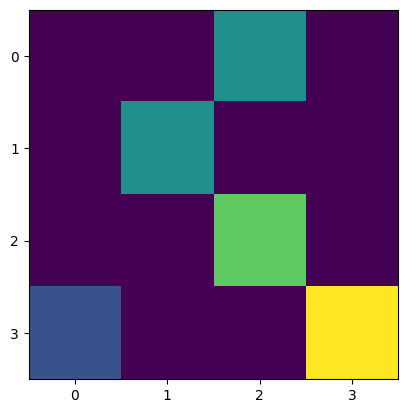

In [470]:
#Initializing the reward
reward_val=0
reward_list = []
time_list = []
eps = []

#SARSA
for episode in range(episodes):
    t = 0
    env.reset()
    state1 = 0
    action1 = choose_action(state1,epsilon)
    reward_val = 0
 
    while t < max_steps:
        # #Visualizing the training
        # env.render()
         
        #Take a time step
        state2, reward, done, info = env.step(action1)
 
        #choose next action
        action2 = choose_action(state2,epsilon)
         
        #update Q vals
        update(state1, state2, reward, action1, action2)

        #keep track of current state
        state1 = state2
        action1 = action2
         
        #Updating the respective values
        t += 1
        reward_val += reward
         
        #If at the end of learning process
        if done:
            break
    reward_list.append(reward_val)
    time_list.append(t)
    eps.append(epsilon)
    epsilon = epsilon*epsilon_decay

env.render()

Performance :  9.453


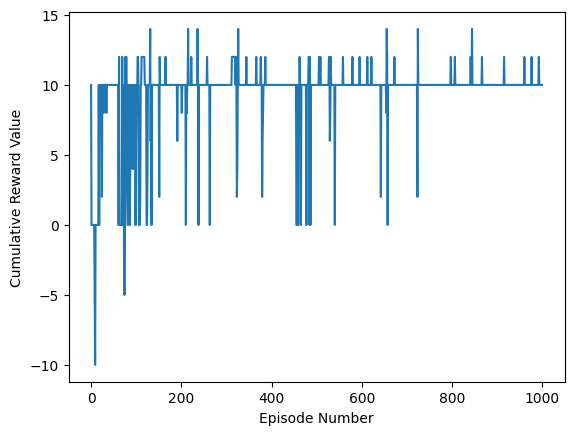

In [471]:
import matplotlib.pyplot as plt
print ("Performance : ", sum(reward_list)/episodes)

plt.plot(list(range(episodes)),reward_list)
plt.xlabel("Episode Number")
plt.ylabel("Cumulative Reward Value")
plt.show()

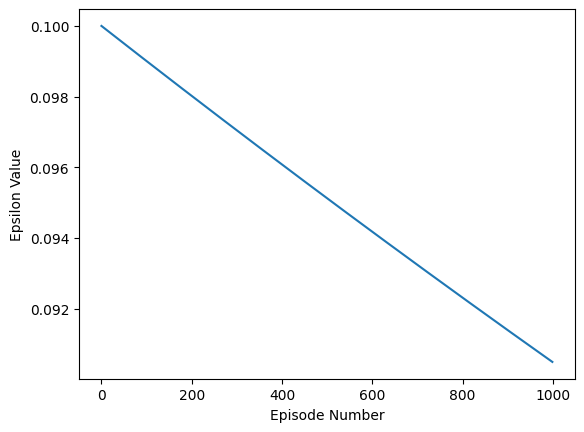

In [472]:
plt.plot(list(range(episodes)),eps)
plt.xlabel("Episode Number")
plt.ylabel("Epsilon Value")
plt.show()

In [473]:
epsilon = 0.2
episodes = 1000
max_steps = 10
alpha = 0.85
gamma = 0.95
epsilon_decay = 0.99

Q = np.zeros((16, 4))

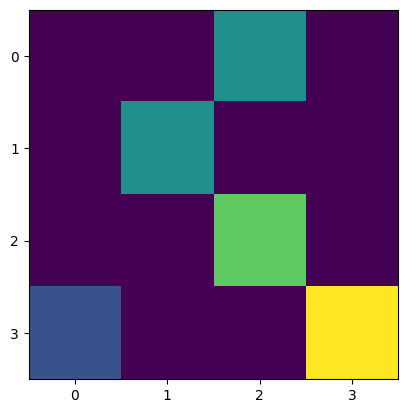

In [474]:
#Initializing the reward
reward_val=0
reward_list = []
time_list = []
sum_reward = 0
sum_reward_list = []
eps = []

#SARSA
for episode in range(episodes):
    t = 0
    env.reset()
    state1 = 0
    action1 = choose_action(state1,epsilon)
    reward_val = 0
 
    while t < max_steps:
        # #Visualizing the training
        # env.render()
         
        #Take a time step
        state2, reward, done, info = env.step(action1)
 
        #choose next action
        action2 = choose_action(state2,epsilon)
         
        #update Q vals
        update(state1, state2, reward, action1, action2)

        #keep track of current state
        state1 = state2
        action1 = action2
         
        #Updating the respective values
        t += 1
        reward_val += reward
         
        #If at the end of learning process
        if done:
            break
    reward_list.append(reward_val)
    time_list.append(t)
    sum_reward += reward_val
    sum_reward_list.append(sum_reward)
    eps.append(epsilon)
    epsilon = epsilon*epsilon_decay

env.render()

Performance :  9.896


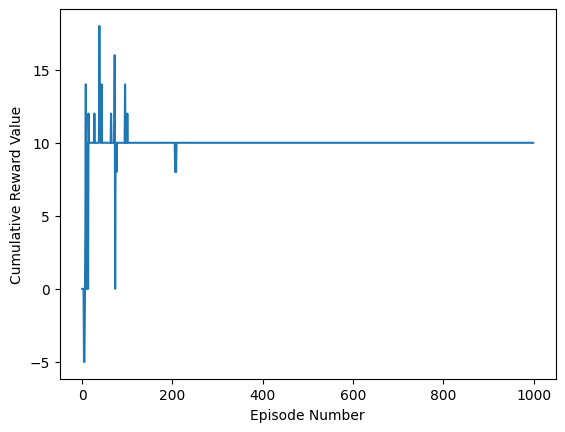

In [475]:
print ("Performance : ", sum(reward_list)/episodes)
plt.plot(list(range(episodes)),reward_list)
plt.xlabel("Episode Number")
plt.ylabel("Cumulative Reward Value")
plt.show()

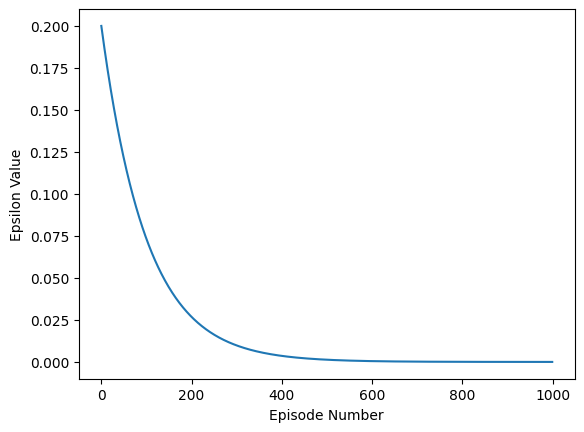

In [476]:
plt.plot(list(range(episodes)),eps)
plt.xlabel("Episode Number")
plt.ylabel("Epsilon Value")
plt.show()

In [517]:
epsilon = 0.5
episodes = 1000
max_steps = 10
alpha = 0.3
gamma = 0.95
epsilon_decay = 0.99

Q = np.zeros((16, 4))

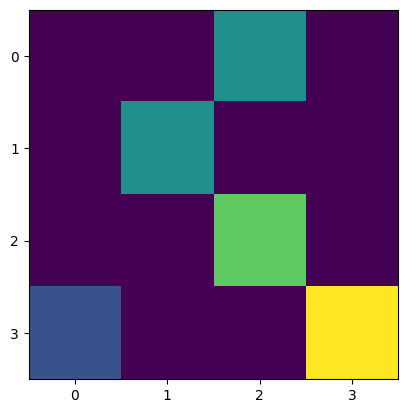

In [518]:
#Initializing the reward
reward_val=0
reward_list = []
time_list = []
eps = []

#SARSA
for episode in range(episodes):
    t = 0
    env.reset()
    state1 = 0
    action1 = choose_action(state1,epsilon)
    reward_val = 0
 
    while t < max_steps:
        # #Visualizing the training
        # env.render()
         
        #Take a time step
        state2, reward, done, info = env.step(action1)
 
        #choose next action
        action2 = choose_action(state2,epsilon)
         
        #update Q vals
        update(state1, state2, reward, action1, action2)

        #keep track of current state
        state1 = state2
        action1 = action2
         
        #Updating the respective values
        t += 1
        reward_val += reward
         
        #If at the end of learning process
        if done:
            break
    reward_list.append(reward_val)
    time_list.append(t)
    eps.append(epsilon)
    epsilon = epsilon * epsilon_decay

env.render()

Performance :  9.906


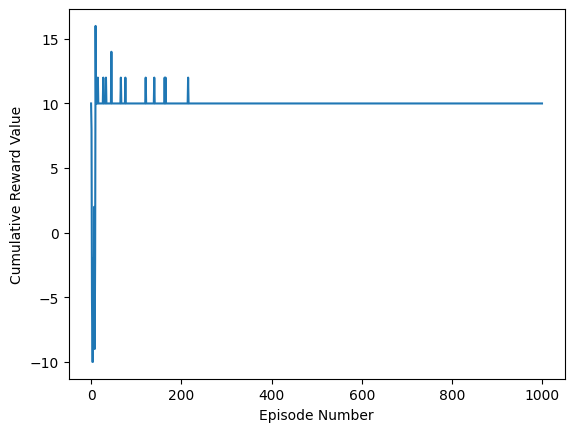

In [519]:
print ("Performance : ", sum(reward_list)/episodes)
plt.plot(list(range(episodes)),reward_list)
plt.xlabel("Episode Number")
plt.ylabel("Cumulative Reward Value")
plt.show()

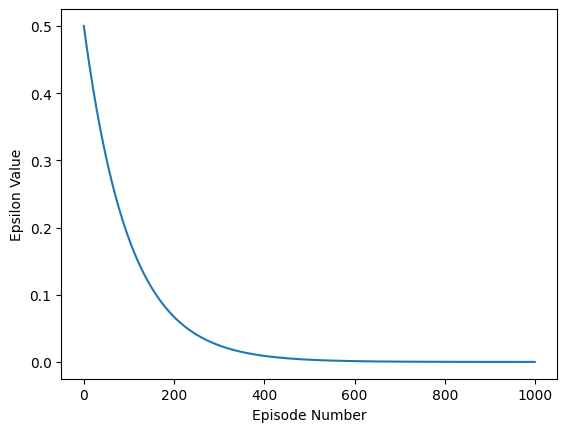

In [520]:
plt.plot(list(range(episodes)),eps)
plt.xlabel("Episode Number")
plt.ylabel("Epsilon Value")
plt.show()

In [521]:
epsilon = 0.5
episodes = 1000
max_steps = 10
alpha = 0.5
gamma = 0.95
epsilon_decay = 0.99

Q = np.zeros((16, 4))

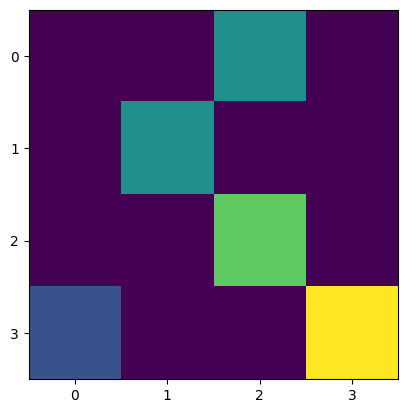

In [522]:
#Initializing the reward
reward_val=0
reward_list = []
time_list = []
eps = []

#SARSA
for episode in range(episodes):
    t = 0
    env.reset()
    state1 = 0
    action1 = choose_action(state1,epsilon)
    reward_val = 0
 
    while t < max_steps:
        # #Visualizing the training
        # env.render()
         
        #Take a time step
        state2, reward, done, info = env.step(action1)
 
        #choose next action
        action2 = choose_action(state2,epsilon)
         
        #update Q vals
        update(state1, state2, reward, action1, action2)

        #keep track of current state
        state1 = state2
        action1 = action2
         
        #Updating the respective values
        t += 1
        reward_val += reward
         
        #If at the end of learning process
        if done:
            break
    reward_list.append(reward_val)
    time_list.append(t)
    eps.append(epsilon)
    epsilon = epsilon * epsilon_decay

env.render()

Performance :  9.825


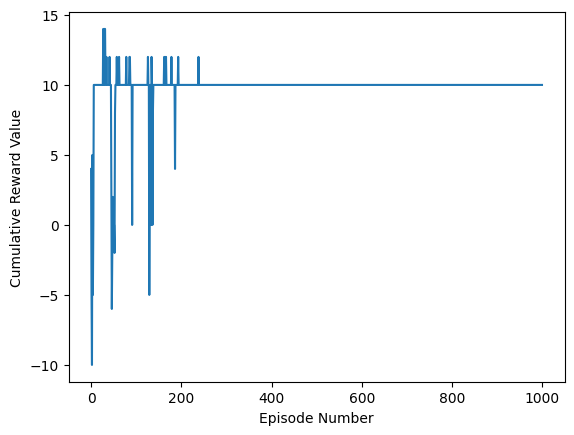

In [523]:
print ("Performance : ", sum(reward_list)/episodes)
plt.plot(list(range(episodes)),reward_list)
plt.xlabel("Episode Number")
plt.ylabel("Cumulative Reward Value")
plt.show()

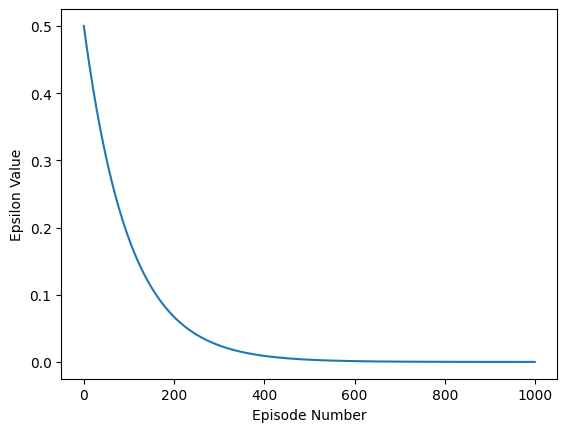

In [524]:
plt.plot(list(range(episodes)),eps)
plt.xlabel("Episode Number")
plt.ylabel("Epsilon Value")
plt.show()

In [525]:
epsilon = 0.5
episodes = 1000
max_steps = 10
alpha = 0.75
gamma = 0.95
epsilon_decay = 0.99

Q = np.zeros((16, 4))

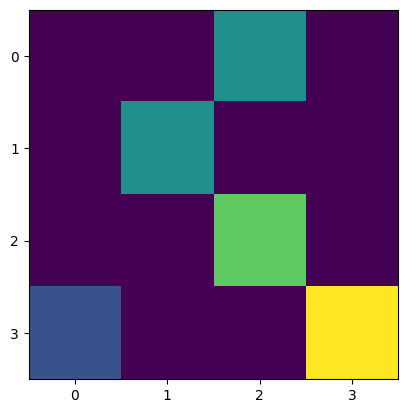

In [526]:
#Initializing the reward
reward_val=0
reward_list = []
time_list = []
eps = []

#SARSA
for episode in range(episodes):
    t = 0
    env.reset()
    state1 = 0
    action1 = choose_action(state1,epsilon)
    reward_val = 0
 
    while t < max_steps:
        # #Visualizing the training
        # env.render()
         
        #Take a time step
        state2, reward, done, info = env.step(action1)
 
        #choose next action
        action2 = choose_action(state2,epsilon)
         
        #update Q vals
        update(state1, state2, reward, action1, action2)

        #keep track of current state
        state1 = state2
        action1 = action2
         
        #Updating the respective values
        t += 1
        reward_val += reward
         
        #If at the end of learning process
        if done:
            break
    reward_list.append(reward_val)
    time_list.append(t)
    eps.append(epsilon)
    epsilon = epsilon * epsilon_decay

env.render()

Performance :  9.928


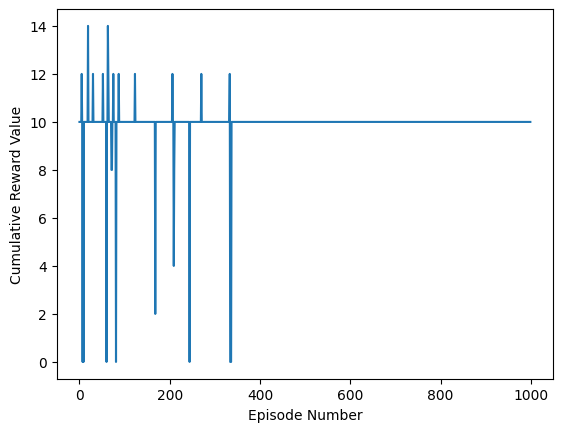

In [527]:
print ("Performance : ", sum(reward_list)/episodes)
plt.plot(list(range(episodes)),reward_list)
plt.xlabel("Episode Number")
plt.ylabel("Cumulative Reward Value")
plt.show()

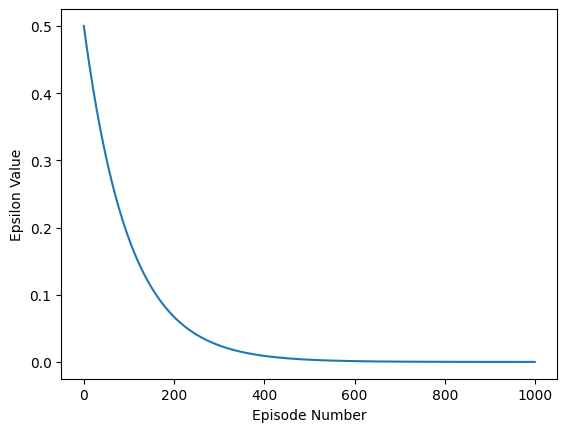

In [528]:
plt.plot(list(range(episodes)),eps)
plt.xlabel("Episode Number")
plt.ylabel("Epsilon Value")
plt.show()

# Part 3: Solve your environment using - Q-learning

In [489]:
#Choose Action
def choose_action(state):
    if np.random.uniform(0, 1) < epsilon:
        action = env.action_space.sample()
    else:
        action = np.argmax(Q[state, :])
    return action

#Update Q
def update(state1, state2, reward, action):
    predict = Q[state1, action]
    target = reward + gamma * np.max(Q[state2, :])
    Q[state1, action] = Q[state1, action] + alpha * (target - predict)

In [490]:
epsilon = 0.8
episodes = 1000
max_steps = 15
alpha = 0.85
gamma = 0.95
epsilon_decay = 0.99

Q = np.zeros((16, 4))

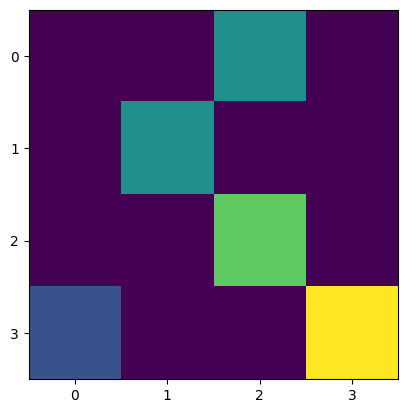

In [491]:
#Initializing the reward
reward_val=0
reward_list = []
time_list = []
sum_reward = 0
sum_reward_list = []
eps = []

#SARSA
for episode in range(episodes):
    t = 0
    env.reset()
    state1 = 0
    reward_val = 0
                
    while t < max_steps:
        #Initialize A
        action1 = choose_action(state1)
                        
        #Take a time step
        state2, reward, done, info = env.step(action1) 
        action2 = choose_action(state2)
        #update Q vals
        update(state1, state2, reward, action1)

        #keep track of current state
        state1 = state2
        action1 = action2
                        
        #Updating the respective values
        t += 1
        reward_val += reward
                        
        #If at the end of learning process
        if done:
            break
    reward_list.append(reward_val)
    time_list.append(t)
    sum_reward += reward_val
    sum_reward_list.append(sum_reward)
    eps.append(epsilon)
    epsilon *= epsilon_decay

env.render()

Performance :  9.945


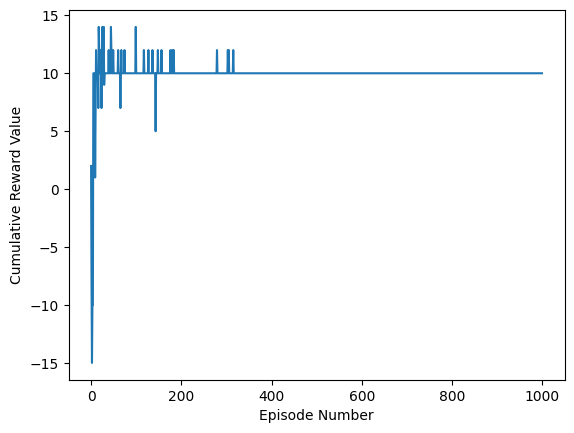

In [492]:
import matplotlib.pyplot as plt
print ("Performance : ", sum(reward_list)/episodes)
#print(best_reward,best_epsilon,best_eps_decay,best_max_steps)
plt.plot(list(range(episodes)),reward_list)
plt.xlabel("Episode Number")
plt.ylabel("Cumulative Reward Value")
plt.show()

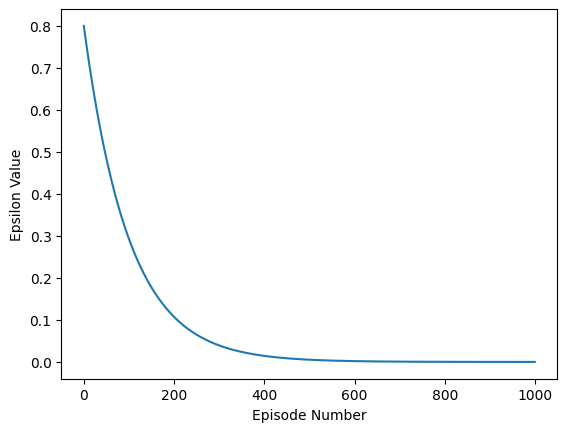

In [493]:
plt.plot(list(range(episodes)),eps)
plt.xlabel("Episode Number")
plt.ylabel("Epsilon Value")
plt.show()

In [494]:
epsilon = 0.75
episodes = 5000
max_steps = 10
alpha = 0.85
gamma = 0.95
epsilon_decay = 0.0005

Q = np.zeros((16, 4))

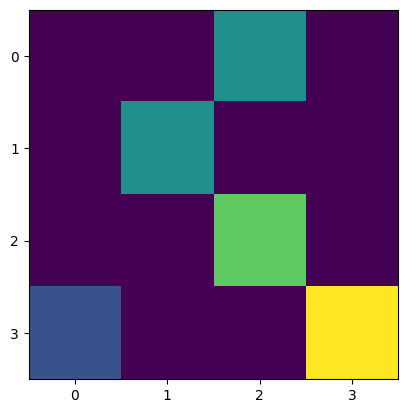

In [495]:
#Initializing the reward
reward_val=0
reward_list = []
time_list = []
sum_reward = 0
sum_reward_list = []
eps = []

#SARSA
for episode in range(episodes):
    t = 0
    env.reset()
    state1 = 0
    reward_val = 0
 
    while t < max_steps:
        #Initialize A
        action1 = choose_action(state1)
         
        #Take a time step
        state2, reward, done, info = env.step(action1)
         
        action2 = choose_action(state2)
        #update Q vals
        update(state1, state2, reward, action1)

        #keep track of current state
        state1 = state2
        action1 = action2
         
        #Updating the respective values
        t += 1
        reward_val += reward
         
        #If at the end of learning process
        if done:
            break
    reward_list.append(reward_val)
    time_list.append(t)
    sum_reward += reward_val
    sum_reward_list.append(sum_reward)
    eps.append(epsilon)
    epsilon -= epsilon_decay

env.render()

Performance :  9.884


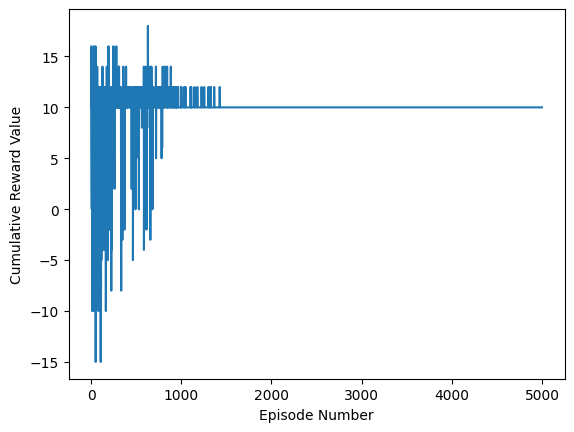

In [496]:
import matplotlib.pyplot as plt
print ("Performance : ", sum(reward_list)/episodes)
plt.plot(list(range(episodes)),reward_list)
plt.xlabel("Episode Number")
plt.ylabel("Cumulative Reward Value")
plt.show()

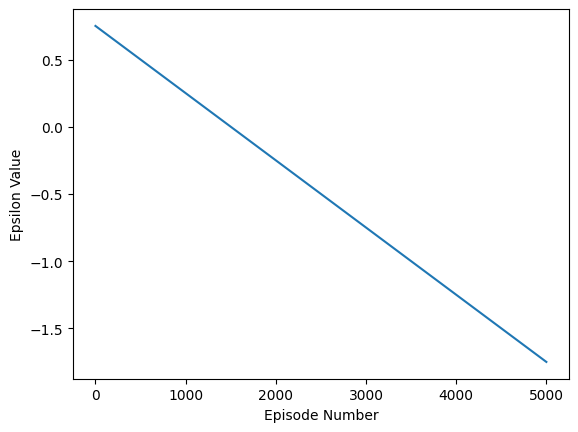

In [497]:
plt.plot(list(range(episodes)),eps)
plt.xlabel("Episode Number")
plt.ylabel("Epsilon Value")
plt.show()

In [498]:
epsilon = 0.5
episodes = 1000
max_steps = 10
alpha = 0.85
gamma = 0.95
epsilon_decay = 0.99

Q = np.zeros((16, 4))

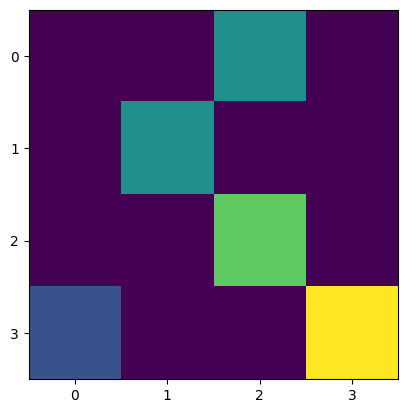

In [499]:
#Initializing the reward
reward_val=0
reward_list = []
time_list = []
sum_reward = 0
sum_reward_list = []
eps = []

#SARSA
for episode in range(episodes):
    t = 0
    env.reset()
    state1 = 0
    reward_val = 0
 
    while t < max_steps:
        #Initialize A
        action1 = choose_action(state1)
         
        #Take a time step
        state2, reward, done, info = env.step(action1)
        
        action2 = choose_action(state2)
        #update Q vals
        update(state1, state2, reward, action1)

        #keep track of current state
        state1 = state2
        action1 = action2
         
        #Updating the respective values
        t += 1
        reward_val += reward

        #If at the end of learning process
        if done:
            break
    reward_list.append(reward_val)
    time_list.append(t)
    sum_reward += reward_val
    sum_reward_list.append(sum_reward)
    eps.append(epsilon)
    epsilon *= epsilon_decay

env.render()

Performance :  9.652


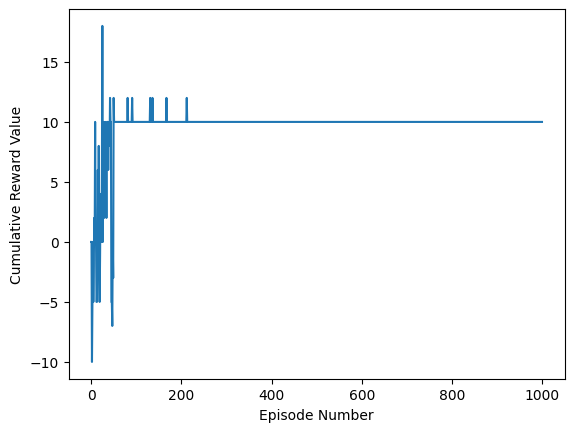

In [500]:
import matplotlib.pyplot as plt
print ("Performance : ", sum(reward_list)/episodes)
plt.plot(list(range(episodes)),reward_list)
plt.xlabel("Episode Number")
plt.ylabel("Cumulative Reward Value")
plt.show()

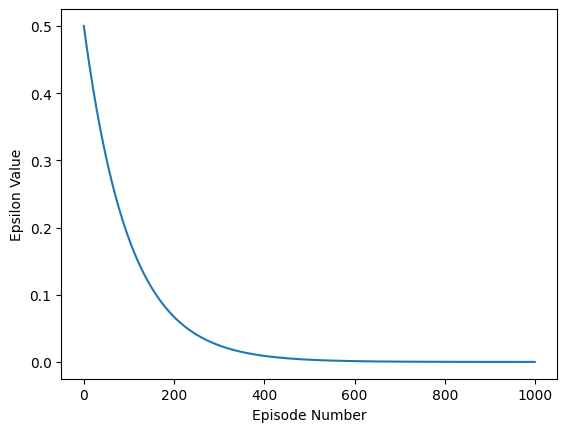

In [501]:
plt.plot(list(range(episodes)),eps)
plt.xlabel("Episode Number")
plt.ylabel("Epsilon Value")
plt.show()

In [502]:
epsilon = 0.8
episodes = 1000
max_steps = 10
alpha = 0.75
gamma = 0.95
epsilon_decay = 0.99

Q = np.zeros((16, 4))

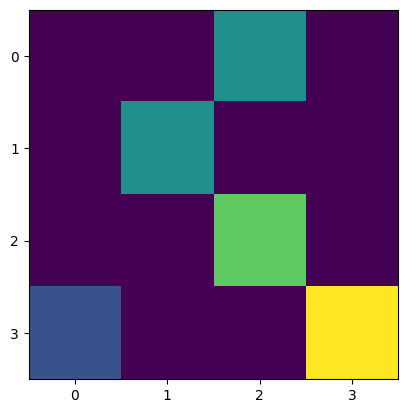

In [503]:
#Initializing the reward
reward_val=0
reward_list = []
time_list = []
sum_reward = 0
sum_reward_list = []
eps = []

#SARSA
for episode in range(episodes):
    t = 0
    env.reset()
    state1 = 0
    reward_val = 0
 
    while t < max_steps:
        #Initialize A
        action1 = choose_action(state1)
         
        #Take a time step
        state2, reward, done, info = env.step(action1)
        
        action2 = choose_action(state2)
        #update Q vals
        update(state1, state2, reward, action1)

        #keep track of current state
        state1 = state2
        action1 = action2
         
        #Updating the respective values
        t += 1
        reward_val += reward

        #If at the end of learning process
        if done:
            break
    reward_list.append(reward_val)
    time_list.append(t)
    sum_reward += reward_val
    sum_reward_list.append(sum_reward)
    eps.append(epsilon)
    epsilon *= epsilon_decay

env.render()

Performance :  9.882


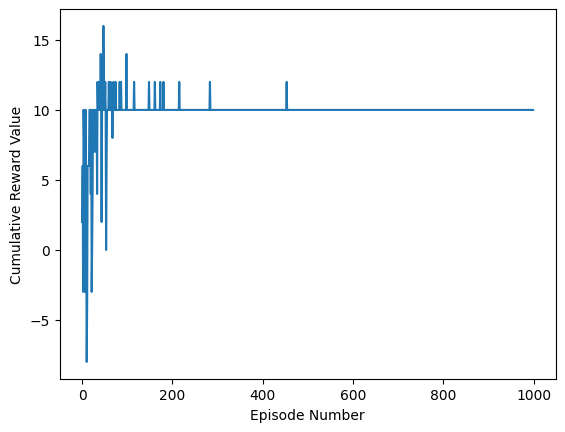

In [504]:
import matplotlib.pyplot as plt
print ("Performance : ", sum(reward_list)/episodes)
plt.plot(list(range(episodes)),reward_list)
plt.xlabel("Episode Number")
plt.ylabel("Cumulative Reward Value")
plt.show()

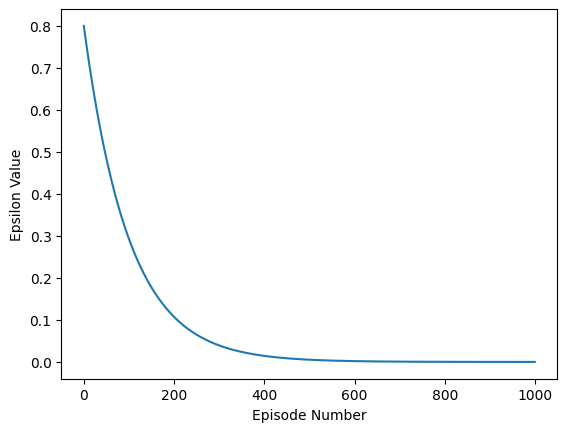

In [505]:
plt.plot(list(range(episodes)),eps)
plt.xlabel("Episode Number")
plt.ylabel("Epsilon Value")
plt.show()

In [506]:
epsilon = 0.8
episodes = 1000
max_steps = 10
alpha = 0.5
gamma = 0.95
epsilon_decay = 0.99

Q = np.zeros((16, 4))

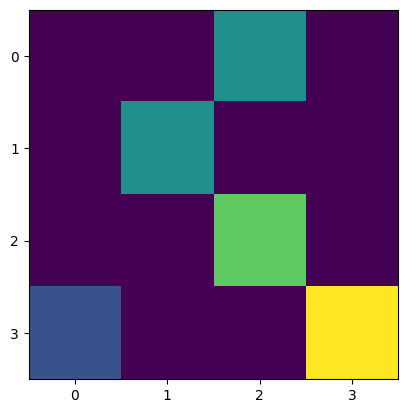

In [507]:
#Initializing the reward
reward_val=0
reward_list = []
time_list = []
sum_reward = 0
sum_reward_list = []
eps = []

#SARSA
for episode in range(episodes):
    t = 0
    env.reset()
    state1 = 0
    reward_val = 0
 
    while t < max_steps:
        #Initialize A
        action1 = choose_action(state1)
         
        #Take a time step
        state2, reward, done, info = env.step(action1)
        
        action2 = choose_action(state2)
        #update Q vals
        update(state1, state2, reward, action1)

        #keep track of current state
        state1 = state2
        action1 = action2
         
        #Updating the respective values
        t += 1
        reward_val += reward

        #If at the end of learning process
        if done:
            break
    reward_list.append(reward_val)
    time_list.append(t)
    sum_reward += reward_val
    sum_reward_list.append(sum_reward)
    eps.append(epsilon)
    epsilon *= epsilon_decay

env.render()

Performance :  9.927


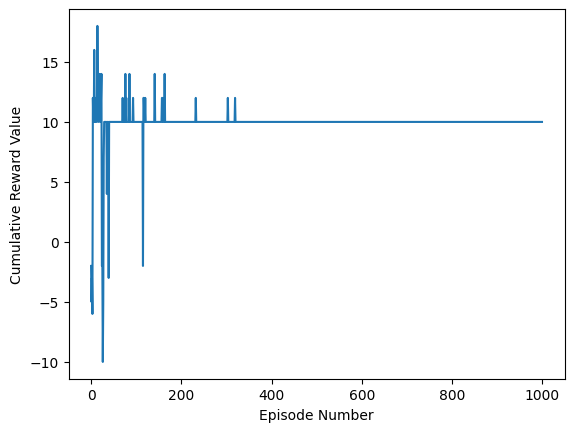

In [508]:
import matplotlib.pyplot as plt
print ("Performance : ", sum(reward_list)/episodes)
plt.plot(list(range(episodes)),reward_list)
plt.xlabel("Episode Number")
plt.ylabel("Cumulative Reward Value")
plt.show()

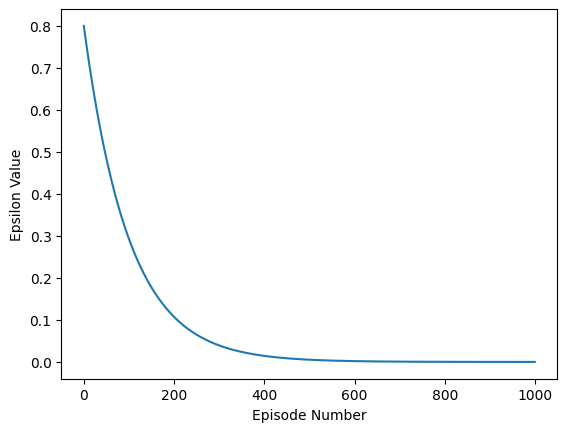

In [509]:
plt.plot(list(range(episodes)),eps)
plt.xlabel("Episode Number")
plt.ylabel("Epsilon Value")
plt.show()

In [510]:
epsilon = 0.8
episodes = 1000
max_steps = 10
alpha = 0.3
gamma = 0.95
epsilon_decay = 0.99

Q = np.zeros((16, 4))

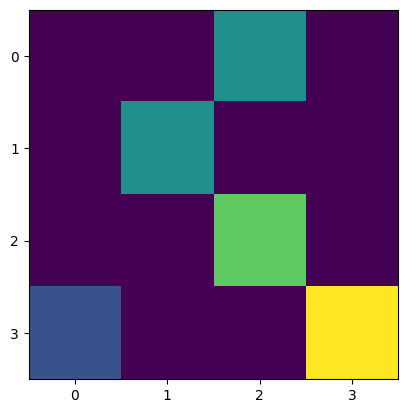

In [511]:
#Initializing the reward
reward_val=0
reward_list = []
time_list = []
sum_reward = 0
sum_reward_list = []
eps = []

#SARSA
for episode in range(episodes):
    t = 0
    env.reset()
    state1 = 0
    reward_val = 0
 
    while t < max_steps:
        #Initialize A
        action1 = choose_action(state1)
         
        #Take a time step
        state2, reward, done, info = env.step(action1)
        
        action2 = choose_action(state2)
        #update Q vals
        update(state1, state2, reward, action1)

        #keep track of current state
        state1 = state2
        action1 = action2
         
        #Updating the respective values
        t += 1
        reward_val += reward

        #If at the end of learning process
        if done:
            break
    reward_list.append(reward_val)
    time_list.append(t)
    sum_reward += reward_val
    sum_reward_list.append(sum_reward)
    eps.append(epsilon)
    epsilon *= epsilon_decay

env.render()

Performance :  9.893


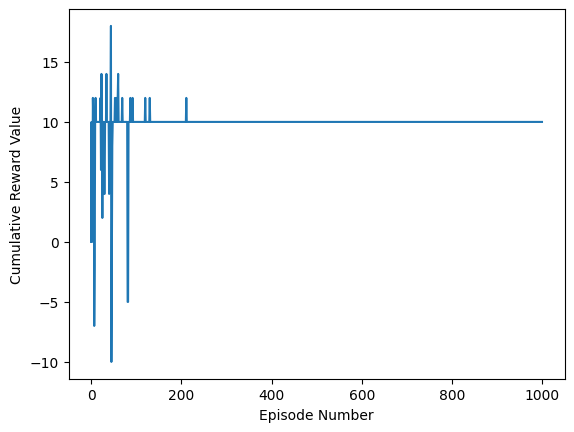

In [512]:
import matplotlib.pyplot as plt
print ("Performance : ", sum(reward_list)/episodes)
plt.plot(list(range(episodes)),reward_list)
plt.xlabel("Episode Number")
plt.ylabel("Cumulative Reward Value")
plt.show()

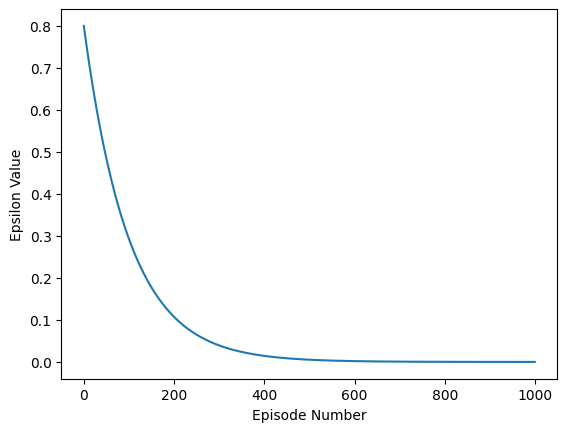

In [513]:
plt.plot(list(range(episodes)),eps)
plt.xlabel("Episode Number")
plt.ylabel("Epsilon Value")
plt.show()